In [1]:
import torch
from dataload import ArtDataset
from torch.utils.data import Dataset, DataLoader, random_split
import math
import torch.nn as nn
import numpy as np
from sklearn import datasets
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import pandas as pd
import torch.optim as optim
from stringproc import create_vocab_csv, text_to_tensor

/opt/anaconda3/envs/pytorch/lib/python3.12/site-packages/torchtext/data/__init__.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHTEXT STATUS /!\ 
Torchtext is deprecated and the last released version will be 0.18 (this one). You can silence this warning by calling the following at the beginnign of your scripts: `import torchtext; torchtext.disable_torchtext_deprecation_warning()`
  warnings.warn(torchtext._TORCHTEXT_DEPRECATION_MSG)
/opt/anaconda3/envs/pytorch/lib/python3.12/site-packages/torchtext/vocab/__init__.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHTEXT STATUS /!\ 
Torchtext is deprecated and the last released version will be 0.18 (this one). You can silence this warning by calling the following at the beginnign of your scripts: `import torchtext; torchtext.disable_torchtext_deprecation_warning()`
  warnings.warn(torchtext._TORCHTEXT_DEPRECATION_MSG)
/opt/anaconda3/envs/pytorch/lib/python3.12/site-packages/torchtext/utils.py:4: UserWarning: 
/!\ IMPORTANT WARNING 

## Initialize the Dataset

In [3]:
# initialize the dataset and the dataloader
dataset = ArtDataset()

Artist Indexed Tokens: tensor([[  101,  3434,  3158,  ...,     0,     0,     0],
        [  101,  2394,  2082,  ...,     0,     0,     0],
        [  101,  9586,  1012,  ...,     0,     0,     0],
        ...,
        [  101,  3744,  1011,  ...,     0,     0,     0],
        [  101,  8149,  1011,  ...,     0,     0,     0],
        [  101,  2726, 12154,  ...,     0,     0,     0]])
 Artist Segment IDs: tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]])
Title Indexed Tokens: tensor([[  101,  1037,  3803,  ...,     0,     0,     0],
        [  101, 14783,  3317,  ...,     0,     0,     0],
        [  101,  1037,  3193,  ...,     0,     0,     0],
        ...,
        [  101,  1996,  3752,  ...,     0,     0,     0],
        [  101,  7095,  3417,  ...,     0,     0,     0],
        [  101,  6533,  1997,  ...,  1037,  2911,  

# Split dataset into train, validation (dev), and test sets
Train: 95%
Validation: 2.5%
Test: 2.5%

In [39]:
# Define the dataset sizes
total_size = len(dataset)
train_size = int(0.10 * total_size)
val_size = int(0.40 * total_size)
test_size = total_size - train_size - val_size

In [40]:
print(train_size, val_size, test_size)

33305 133223 166531


In [41]:
# Split dataset into train, validation (dev), and test sets
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

In [42]:
print(len(train_dataset))

33305


In [43]:
# Higher batch size seems to make the model train faster, but converge happens slower 
batch = 128 

# Create dataloaders for the training, validation, and test sets
train_loader = DataLoader(train_dataset, batch_size=batch, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=batch, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=batch, shuffle=False, num_workers=2)

## Importing and Testing BERT embeddings
BERT allows us to extract context dependent embeddings of each word in a given sentence. For instance, in the phrases "river bank" and "bank of America" the word bank would end up having a drastically different embedding. We test BERT's ability to recognize artist names, and embed them to vectors close to other artists of similar statures and time periods. 

#### INCLUDE CITATION
Chris McCormick and Nick Ryan. (2019, May 14). *BERT Word Embeddings Tutorial*. Retrieved from http://www.mccormickml.com

In [9]:
# Import the pretrained BERT Model
from transformers import BertModel, BertForSequenceClassification

# if you want to have more information on what's happening, activate the logger as follows
import logging
#logging.basicConfig(level=logging.INFO)

In [10]:
# Load pre-trained model (weights)
base_model = BertModel.from_pretrained('bert-base-uncased',
                                  output_hidden_states = True, # Whether the model returns all hidden-states
                                  num_labels=13                            
                                  )

# Put the model in "evaluation" mode, meaning feed-forward operation.
base_model.eval()

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSdpaSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False

In [13]:
# function: prediction_to_real_price 
# ------------------------------------------------------
# converts the normalized price tensor back to the original tensor 
# 
# @param price_tensor Tensor containing the price we would like to convert 
# to the original price 
# 
# @returns Original Price
def prediction_to_real_price(price_tensor): 
    return (price_tensor * dataset.price_std) + dataset.price_median

# Sample the Training Set 
index = 1004
artist_tokens_tensor, artist_segids, price_tensor, price_classifier = dataset.__getitem__(index)
artist_tokens_tensor = artist_tokens_tensor.view(1, -1)
artist_segids = artist_segids.view(1, -1)
print(artist_tokens_tensor)
print(artist_tokens_tensor.shape)
print(artist_segids)
print(artist_segids.shape)
print(price_classifier)
#artist_str, title_str = dataset.__getstring__(index)
#print(f"Artist: {artist_str}")
#print(f"Title: {title_str}")

tensor([[  101,  1037,  3940,  1997,  3756,  3384,  9226,  2275, 26450, 13767,
          2015,  1010,  1037, 28653,  2275,  3614,  1006,  2962, 13366, 20132,
          1007,  1010,  1037,  2962,  2275,  3614,  1010,  1037,  3940,   102]])
torch.Size([1, 30])
tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1]])
torch.Size([1, 30])
tensor([1])


In [14]:
from transformers import BertTokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Takes in a string and outputs a list of the indices of the 
# words inside, and the tokens 
def encode_text(text): 
    # Add the special tokens.
    marked_text = "[CLS] " + text + " [SEP]"

    # Split the sentence into tokens.
    tokenized_text = tokenizer.tokenize(marked_text)

    # Map the token strings to their vocabulary indeces.
    indexed_tokens = tokenizer.convert_tokens_to_ids(tokenized_text)
    return tokenized_text, indexed_tokens

In [15]:
tokenized_text, indexed_tokens = encode_text("Artist Name from Christie Auction Lot: Duane Hanson")

# Display the words with their indeces.
for tup in zip(tokenized_text, indexed_tokens):
    print('{:<12} {:>6,}'.format(tup[0], tup[1]))

[CLS]           101
artist        3,063
name          2,171
from          2,013
christie     13,144
auction      10,470
lot           2,843
:             1,024
duane        27,319
hanson       17,179
[SEP]           102


In [16]:
# Mark each of the tokens as belonging to sentence "1".
segments_ids = [1] * len(tokenized_text)

print (segments_ids)

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


In [17]:
# Convert inputs to PyTorch tensors
tokens_tensor_test = torch.tensor([indexed_tokens])
segments_tensors_test = torch.tensor([segments_ids])

In [18]:
# Run the text through BERT, and collect all of the hidden states produced
# from all 12 layers.
with torch.no_grad():

    outputs = base_model(tokens_tensor_test, segments_tensors_test)

    # Evaluating the model will return a different number of objects based on
    # how it's  configured in the `from_pretrained` call earlier. In this case,
    # becase we set `output_hidden_states = True`, the third item will be the
    # hidden states from all layers. See the documentation for more details:
    # https://huggingface.co/transformers/model_doc/bert.html#bertmodel
    hidden_states = outputs[2]

In [19]:
# Concatenate the tensors for all layers. We use `stack` here to
# create a new dimension in the tensor.
token_embeddings = torch.stack(hidden_states, dim=0)

token_embeddings.size()

torch.Size([13, 1, 11, 768])

In [20]:
# Remove dimension 1, the "batches".
token_embeddings = torch.squeeze(token_embeddings, dim=1)

token_embeddings.size()

torch.Size([13, 11, 768])

In [21]:
# Stores the token vectors, with shape [22 x 3,072]
token_vecs_cat = []

# `token_embeddings` is a [22 x 12 x 768] tensor.

# For each token in the sentence...
for token in token_embeddings:

    # `token` is a [12 x 768] tensor

    # Concatenate the vectors (that is, append them together) from the last
    # four layers.
    # Each layer vector is 768 values, so `cat_vec` is length 3,072.
    cat_vec = torch.cat((token[-1], token[-2], token[-3], token[-4]), dim=0)

    # Use `cat_vec` to represent `token`.
    token_vecs_cat.append(cat_vec)

print ('Shape is: %d x %d' % (len(token_vecs_cat), len(token_vecs_cat[0])))

Shape is: 13 x 3072


In [24]:
# Stores the token vectors, with shape [22 x 768]
token_vecs_sum = []

# `token_embeddings` is a [22 x 12 x 768] tensor.

# For each token in the sentence...
for token in token_embeddings:

    # `token` is a [12 x 768] tensor

    # Sum the vectors from the last four layers.
    sum_vec = torch.sum(token[-4:], dim=0)

    # Use `sum_vec` to represent `token`.
    token_vecs_sum.append(sum_vec)

print ('Shape is: %d x %d' % (len(token_vecs_sum), len(token_vecs_sum[0])))

Shape is: 13 x 768


In [25]:
for i, token_str in enumerate(tokenized_text):
  print (i, token_str)

0 [CLS]
1 artist
2 name
3 from
4 christie
5 auction
6 lot
7 :
8 duane
9 hanson
10 [SEP]


In [31]:
print("Duane", str(token_vecs_sum[8][:7]))
print("Hanson", str(token_vecs_sum[9][:7]))

Duane tensor([ 0.0679, -1.3539,  0.1005, -0.4218,  0.3941,  1.3565,  2.5718])
Hanson tensor([-2.2877e-01, -6.0235e-01, -1.6311e-03, -5.5483e-01,  1.5981e-01,
         1.8523e+00,  2.3278e+00])


In [32]:
from scipy.spatial.distance import cosine

# Calculate the cosine similarity between the word Hanson
# in "Duane Hanson" vs the band "Hanson" (different meanings).
diff_hanson = 1 - cosine(token_vecs_sum[2], token_vecs_sum[10])

# Calculate the cosine similarity between the word Hanson
# in "Duane Hanson" vs "Henry Moore" (another sculptor).
sculptors = 1 - cosine(token_vecs_sum[2], token_vecs_sum[5])

print('Vector similarity for  two sculptors:  %.2f' % sculptors)
print('Vector similarity for *different* Hansons:  %.2f' % diff_hanson)

Vector similarity for  two sculptors:  0.80
Vector similarity for *different* Hansons:  0.58


## Define the Models
We define the following models: 
+ A BERT classifier: A pretrained transformer model for classification of sequence text data into a specified number of categories. We will specialize this model to classify the predicted real price ($) of artworks into 13 different price categories: 0-50, 50-100, 100-250, 250-500, 500-750, 750-1000, 1000-5000, 5000-10000, 10000-50000, 50000-100000, 100000-500000, 500000-1M, 1M+. 

In [ ]:
from transformers import BertForSequenceClassification

model = BertForSequenceClassification.from_pretrained(
    'bert-base-uncased',
    num_labels=len(set(dataset.price_classifier)),  # Number of classes
)

## Define the loss function as mean average percentage error
We are using this for when we predict the price itself. The reason for this is that we do not want to penalize a prediction that is off by 5 dollars equally for a 1M dollar painting as for a 50 dollar painting. 

In [113]:
# Define percentage error loss
# We use percentage error so that errors on large prices are treated more leniently than errors on small prices 
class MAPE(nn.Module):
    def __init__(self, epsilon=1e-8):
        super(MAPE, self).__init__()
        self.epsilon = epsilon  # Small constant to avoid division by zero

    def forward(self, predictions, targets):
        # Calculate MAPE
        percentage_errors = torch.abs((targets - predictions) / (targets + self.epsilon))
        mape = 100.0 * torch.mean(percentage_errors)
        return mape

## Train the models using Mini-Batch Gradient Descent with ADAM

In [33]:
from transformers import AdamW
from torch.optim import lr_scheduler

# Optimizer
optimizer = AdamW(model.parameters(), lr=2e-5, eps=1e-8)

# Scheduler
scheduler = lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.1)

/opt/anaconda3/envs/pytorch/lib/python3.12/site-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [ ]:
from torch.nn import CrossEntropyLoss
from transformers import get_scheduler

# Loss function
criterion = CrossEntropyLoss()

# Training loop
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

num_epochs = 1

losses = []
epoch_losses = []
for epoch in range(num_epochs):
    model.train()
    for artist, artist_seg_ids, price, price_classifier in train_loader:
        print("Zeroing out the gradients")
        optimizer.zero_grad()

        # Forward pass
        print("Making the forward pass")
        outputs = model(input_ids=artist, attention_mask=artist_seg_ids, 
                        labels=price_classifier)
        print("Computing the loss")
        loss = outputs.loss
        print(f'Loss: {loss.item()}')
        losses.append(loss.item())

        print("Doing backward propagation")
        loss.backward()

        print("Adjusting the parameters")
        optimizer.step()

    # Save a copy of the model weights after each epoch so we don't lose our progress
    model.save_pretrained("./fine_tuned_bert")
    epoch_losses.append(loss.item())
    print(f"Epoch {epoch + 1}, Loss: {loss.item()}")

    # Scheduler step
    scheduler.step()

/opt/anaconda3/envs/pytorch/lib/python3.12/site-packages/torchtext/data/__init__.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHTEXT STATUS /!\ 
Torchtext is deprecated and the last released version will be 0.18 (this one). You can silence this warning by calling the following at the beginnign of your scripts: `import torchtext; torchtext.disable_torchtext_deprecation_warning()`
  warnings.warn(torchtext._TORCHTEXT_DEPRECATION_MSG)
/opt/anaconda3/envs/pytorch/lib/python3.12/site-packages/torchtext/data/__init__.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHTEXT STATUS /!\ 
Torchtext is deprecated and the last released version will be 0.18 (this one). You can silence this warning by calling the following at the beginnign of your scripts: `import torchtext; torchtext.disable_torchtext_deprecation_warning()`
  warnings.warn(torchtext._TORCHTEXT_DEPRECATION_MSG)
/opt/anaconda3/envs/pytorch/lib/python3.12/site-packages/torchtext/vocab/__init__.py:4: UserWarning: 
/!\ IMPORTANT 

Zeroing out the gradients
Making the forward pass
Computing the loss
Loss: 3.6128101348876953
Doing backward propagation
Adjusting the parameters
Zeroing out the gradients
Making the forward pass
Computing the loss
Loss: 3.4017815589904785
Doing backward propagation
Adjusting the parameters
Zeroing out the gradients
Making the forward pass
Computing the loss
Loss: 2.9808945655822754
Doing backward propagation
Adjusting the parameters
Zeroing out the gradients
Making the forward pass
Computing the loss
Loss: 3.351076602935791
Doing backward propagation
Adjusting the parameters
Zeroing out the gradients
Making the forward pass
Computing the loss
Loss: 3.0037050247192383
Doing backward propagation
Adjusting the parameters
Zeroing out the gradients
Making the forward pass
Computing the loss
Loss: 3.2800509929656982
Doing backward propagation
Adjusting the parameters
Zeroing out the gradients
Making the forward pass
Computing the loss
Loss: 3.0588364601135254
Doing backward propagation
Adju

Training one epoch...
Loss at step 0: 100.01216888427734
Loss at step 100: 104.21656036376953
Loss at step 200: 98.885498046875
Loss at step 300: 97.80712127685547
Loss at step 400: 99.3489761352539
Loss at step 500: 98.05636596679688
Loss at step 600: 99.31829833984375
Loss at step 700: 99.65673828125
Loss at step 800: 99.76976013183594
Loss at step 900: 98.59403228759766
Loss at step 1000: 98.342041015625
Loss at step 1100: 98.83724212646484
Loss at step 1200: 98.95890045166016


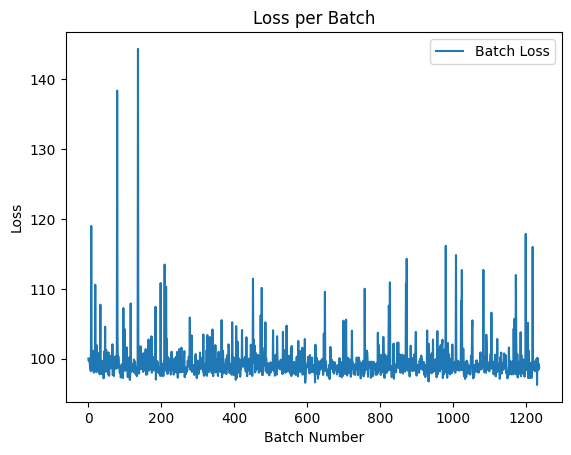

In [119]:
# Plot the loss curve
plt.plot(losses, label="Batch Loss")
plt.xlabel("Batch Number")
plt.ylabel("Loss")
plt.title("Loss per Batch")
plt.legend()
plt.show()

## Compute human error
Compute the average human error based on choosing the middle of the auctioneer's estimate as the auctioneer's prediction for that lot

In [68]:
import pandas as pd

# Load the CSV file
file_path = 'clean_art.csv'
data = pd.read_csv(file_path)

# Calculate the human predicted price (midpoint)
data['Human Predicted Price'] = (data['Real LB Estimate USD'] + data['Real UB Estimate USD']) / 2

# Calculate the absolute percentage error for each row
data['Absolute Percentage Error'] = abs(data['Human Predicted Price'] - data['Real Price USD']) / data['Real Price USD']

# Calculate the mean of the absolute percentage error (MAPE)
mape = data['Absolute Percentage Error'].mean() * 100

# Output the result
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")

Mean Absolute Percentage Error (MAPE): 39.08%
